In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import glob
import math
import numpy as np
import random
import itertools
import sklearn.metrics as metrics

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.initializers import Constant

In [2]:
# For reproducibility
random.seed(7493)
np.random.seed(7493)

In [3]:
def next_batch(data, size):
    for item in itertools.cycle(data):
        perm = np.random.permutation(item['Y'].shape[0])
        for i in np.arange(0, item['Y'].shape[0], size):
#             print 'i:', i, 'shape:', item['Y'].shape[0], 'size:', size
            yield (item['X'][perm[i:i + size]], item['Y'][perm[i:i + size]])

In [4]:
def unfold(data):
    x, y = np.array(data[0]['X']), np.array(data[0]['Y'])
    for item in data[1:]:
        x = np.concatenate((x, item['X'])); y = np.concatenate((y, item['Y']))
    return (x, y)

In [5]:
def count_samples(data):
    return np.sum([item['Y'].shape[0] for item in data])

def count_steps(data, batch_size):
    return int(np.sum([item['Y'].shape[0]/batch_size for item in data]))

In [6]:
def load_data(path):
    # Load all npz files from path
    return np.array([np.load(np_name) for np_name in glob.glob(os.path.join(path, '*.np[yz]'))])

In [7]:
def split_data(data, split=0.1):
    """
    Split data into train and test set
    """
    i = int(len(data)*split)
    perm = np.random.permutation(len(data)) # permute data
    return data[perm[i:]], data[perm[0:i]] # return training, test sets

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def plot_roc_curve(n_classes, y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    roc_score = metrics.roc_auc_score(y_true, y_pred)

    #print "Loss: {} Accuracy: {}%".format(loss_and_metrics[0],loss_and_metrics[1] * 100)
    print "ROC AUC Score: ", roc_score

In [10]:
def build_model(lr=1e-5, batch_size=64, decay=0, m=0.5, ridge=2e-4, init='he_normal'):
    adam = Adam(lr=lr, decay=decay)
    bias_init = Constant(value=0.1)
    model = Sequential()

    model.add(Conv1D(25, 50, padding='valid', input_shape=(15000, 3), kernel_initializer=init, bias_initializer=bias_init))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(25, 50, padding='valid', kernel_initializer=init, bias_initializer=bias_init))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling1D())
    model.add(Flatten())

    model.add(Dense(1024, kernel_initializer=init, bias_initializer=bias_init, kernel_regularizer=l2(ridge)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(5, kernel_initializer=init, bias_initializer=bias_init, kernel_regularizer=l2(ridge)))
    model.add(Activation('softmax'))

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
def train_model(data, k_folds=9, batch_size=192, epochs=100, lr=1e-5, decay=0.9, m=0.5, ridge=2e-4):
    model = build_model(lr=lr, batch_size=batch_size, decay=decay, m=m, ridge=ridge)
    model.summary()
    fold_size = int(math.ceil(len(data)/k_folds))
    earlyStopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    
    for k in range(k_folds):
        i = int(k * fold_size)
        val = data[i:i+fold_size]
        train = np.concatenate((data[:i],data[i+fold_size:]))
#         steps_per_epoch = int(count_samples(train) / batch_size)
        steps_per_epoch = count_steps(train, batch_size)
        print 'Fold:',(k+1),'Samples:',count_samples(train),'Epochs:',epochs,'Steps:',steps_per_epoch
        
        name = 'f' + str(k+1) + '-e' + str(epochs) + '-lr' + str(lr)+ '-dcy' + str(decay) + '-mntm' + str(m) + '-reg' + str(ridge)
        filepath = './history/DS_' + name + '_{epoch:03d}-{val_acc:.2f}.h5'
        checkpointer = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0, save_best_only=True)
        
        model.fit_generator(next_batch(train, batch_size), steps_per_epoch, epochs=epochs, verbose=2,
                            validation_data=unfold(val),
                            callbacks=[checkpointer, earlyStopper])
        
    return model

In [12]:
def test_model(model, test, batch_size=192):
    # Test model on test set
    test_x, y_true = unfold(test)
    loss_and_metrics = model.evaluate(test_x, y_true, batch_size=batch_size, verbose=1)
    y_pred = model.predict(test_x, batch_size=batch_size, verbose=1)
    
    y_true_class = np.argmax(y_true, axis=1)
    y_pred_class = np.argmax(y_pred, axis=1)
    conf_mat = metrics.confusion_matrix(y_true_class, y_pred_class)
    
    print "Test Loss and accuracy: ", loss_and_metrics
    plot_roc_curve(5, y_true, y_pred)
    plot_confusion_matrix(conf_mat, classes=['S1', 'S2', 'S3', 'A', 'R'])

In [ ]:
def setup(data_dir, k_folds=9, batch_size=192, epochs=100, lr=1e-5, decay=0.9, m=0.5, ridge=2e-4):
    data = load_data(data_dir)
    data, test = split_data(data)
    model = train_model(data, k_folds=k_folds, batch_size=batch_size, epochs=epochs, lr=lr, decay=decay, m=m, ridge=ridge)
    test_model(model, test, batch_size=batch_size)

In [ ]:
if __name__ == "__main__":
    print 'Setting up'
    setup('/home/afguerrerohernan/data/patients_processed/')
    print 'Training completed'

Setting up
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14951, 25)         3775      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14951, 25)         100       
_________________________________________________________________
activation_1 (Activation)    (None, 14951, 25)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14902, 25)         31275     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14902, 25)         100       
_________________________________________________________________
activation_2 (Activation)    (None, 14902, 25)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7451, 25)          0         

In [ ]:
# data = load_data('/home/afguerrerohernan/data/patients_processed/')
# data, test = split_data(data)
# model = train_model(data, k_folds=9, batch_size=192, epochs=1, lr=1e-5, decay=0.9, m=0.5, ridge=2e-4)

In [ ]:
# test_model(model, test, batch_size=192)

In [16]:
conf_mat = np.array([[16,130,8,0,87],[24,1572,63,9,94],[0,83,234,0,0],[52,104,132,32,39],[39,224,6,22,498]])

Confusion matrix, without normalization
[[  16  130    8    0   87]
 [  24 1572   63    9   94]
 [   0   83  234    0    0]
 [  52  104  132   32   39]
 [  39  224    6   22  498]]


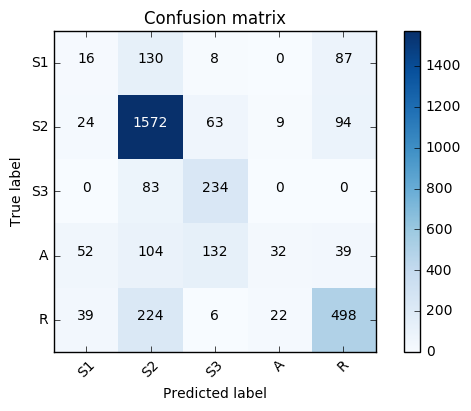

In [19]:
plot_confusion_matrix(conf_mat, classes=['S1', 'S2', 'S3', 'A', 'R'])